## **Products categorization with Distilbert model**

The project concerns product categorization (multi-class text classification) based on their description by using pre-trained Distilbert model. Based on given text as an input, we have predicted what would be the category. In our analysis we have used a Huggingface (transformers) library as well.



In [4]:
#!pip install transformers

**Importing the required libraries**

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.metrics import confusion_matrix, accuracy_score

import tensorflow as tf
from tensorflow import keras 
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from keras.models import Model
from tensorflow.keras import utils as np_utils
from keras.utils.np_utils import to_categorical

import transformers
from transformers import AutoTokenizer,TFDistilBertModel, DistilBertConfig
from transformers import TFAutoModel

import warnings
warnings.filterwarnings("ignore")

C:\Users\rachel\anaconda3\envs\tf\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
print(tf.__version__)
print(keras.__version__)

2.6.0
2.6.0


We load previous cleaned up dataset.

In [7]:
df = pd.read_csv('labelled_data_objective_subjective_usa.csv')
df.head()

,Unnamed: 0.1,Unnamed: 0,Text,new_text,languages,new_text_after_translation,pos_tagged_words,words_processed_all,words_processed_noun_adj_verb_adv,words_processed_noun,subjectivity,text_type
0,0,0,want find way end racism try force people inje...,want find way end racism try force people inje...,ENGLISH,want find way end racism try force people inje...,"[('want', 'JJ'), ('find', 'VB'), ('way', 'NN')...","['want', 'find', 'way', 'end', 'racism', 'try'...","['want', 'find', 'way', 'end', 'racism', 'try'...","['way', 'end', 'racism', 'force', 'people', 'b...",0.200000,opinion-based
1,1,1,"this child almost died tetanus, spent months h...","this child almost died tetanus, spent months h...",ENGLISH,"this child almost died tetanus, spent months h...","[('this', 'DT'), ('child', 'NN'), ('almost', '...","['child', 'almost', 'died', 'tetanus', 'spent'...","['child', 'almost', 'die', 'tetanus', 'spend',...","['child', 'tetanus', 'month', 'hospital', 'cos...",0.100000,opinion-based
2,2,2,juste se rappeler m. leblanc la pression que l...,juste se rappeler m. leblanc la pression que l...,ENGLISH,just remember mr. leblanc the pressure that th...,"[('just', 'RB'), ('remember', 'VB'), ('my', 'P...","['remember', 'leblanc', 'pressure', 'provincia...","['remember', 'leblanc', 'pressure', 'provincia...","['leblanc', 'pressure', 'business', 'world', '...",0.625000,opinion-based
3,3,3,"you would expect cases rise significantly, cou...","you would expect cases rise significantly, cou...",ENGLISH,"you would expect cases rise significantly, cou...","[('you', 'PRP'), ('would', 'MD'), ('expect', '...","['would', 'expect', 'case', 'rise', 'significa...","['would', 'expect', 'case', 'rise', 'significa...","['case', 'vaccination', 'rate', 'play', 'space...",0.459821,opinion-based
4,4,4,depends whether vaccination status is embedded...,depends whether vaccination status is embedded...,ENGLISH,depends whether vaccination status is embedded...,"[('depends', 'VBZ'), ('whether', 'IN'), ('vacc...","['depends', 'whether', 'vaccination', 'status'...","['depend', 'vaccination', 'status', 'embed', '...","['vaccination', 'status', 'code', 'link', 'con...",0.000000,opinion-based


In [8]:
df.shape

(1409, 12)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1409 entries, 0 to 1408
Data columns (total 12 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Unnamed: 0.1                       1409 non-null   int64  
 1   Unnamed: 0                         1409 non-null   int64  
 2   Text                               1409 non-null   object 
 3   new_text                           1409 non-null   object 
 4   languages                          1409 non-null   object 
 5   new_text_after_translation         1409 non-null   object 
 6   pos_tagged_words                   1409 non-null   object 
 7   words_processed_all                1409 non-null   object 
 8   words_processed_noun_adj_verb_adv  1409 non-null   object 
 9   words_processed_noun               1409 non-null   object 
 10  subjectivity                       1409 non-null   float64
 11  text_type                          1409 non-null   objec

In [10]:
#types of categories
df['text_type'].value_counts()

opinion-based    1055
fact-based        354
Name: text_type, dtype: int64

### **Data preparation**

Spliting the data into train and test sets:

In [11]:
texts = df['words_processed_noun']
y = df['text_type']

In [12]:
texts

0       ['way', 'end', 'racism', 'force', 'people', 'b...
1       ['child', 'tetanus', 'month', 'hospital', 'cos...
2       ['leblanc', 'pressure', 'business', 'world', '...
3       ['case', 'vaccination', 'rate', 'play', 'space...
4       ['vaccination', 'status', 'code', 'link', 'con...
                              ...                        
1404    ['day', 'headstart', 'restaurant', 'basic', 'c...
1405    ['top', 'office', 'science', 'technology', 'po...
1406    ['letter', 'decepticon', 'expectation', 'insti...
1407     ['couid', 'vaccine', 'vaccine', 'age', 'chance']
1408    ['guest', 'board', 'cruise', 'port', 'line', '...
Name: words_processed_noun, Length: 1409, dtype: object

In [13]:
new_text_noun = []

for row in texts:
    new_row = row.strip("][").replace("'","").split(", ")
    new_row = " ".join(new_row)
    new_text_noun.append(new_row)

In [14]:
new_text_noun

['way end racism force people bunch people race vaccination people amp support people force',
 'child tetanus month hospital cost parent vaccination pandemic',
 'leblanc pressure business world border air traffic block tourist vaccination hotel restaurant',
 'case vaccination rate play space adult space people school age student datum state bear',
 'vaccination status code link connect end read',
 'isolation question look spike matter vaccination thing',
 'vaccination center parent mask amp amp answer',
 'tool suite leader combat vaccine hesitancy resistance video article',
 'vaccine goal vaccination blogger news accident vaccine step competence',
 'head brain place vaccination rate case_count dictatorship name',
 'vaccination world passport goal populationcontrol',
 'vaccination vaccination restaurant arena fitness center vaccination rate',
 'age hour infection amp booster infection protect hypnotoad pheromone',
 '',
 'business vaccination mandate',
 'understand link vaccination compu

In [15]:
df2 = pd.DataFrame(new_text_noun)

In [16]:
df2

,0
0,way end racism force people bunch people race ...
1,child tetanus month hospital cost parent vacci...
2,leblanc pressure business world border air tra...
3,case vaccination rate play space adult space p...
4,vaccination status code link connect end read
...,...
1404,day headstart restaurant basic career demand f...
1405,top office science technology policy couid vac...
1406,letter decepticon expectation institution lead...
1407,couid vaccine vaccine age chance


In [17]:
X = df2[0]

In [18]:
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.2, random_state = 1)

In [19]:
encoder = LabelEncoder()
encoder.fit(y_train)

y_train = encoder.transform(y_train)
y_test = encoder.transform(y_test)

num_classes = np.max(y_train) + 1
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

### **DistilBERT model**

**DistilBERT**is a distilled version of BERT: smaller,faster, cheaper and lighter. It is a small, fast, cheap and light Transformer model trained by distilling BERT base. Because the BERT model has large size, it is difficult fot it to put it into production. Sometimes we want to use these model when we need a less weight yet efficient model. That's when we can use Distil-BERT model. It is  a smaller general-purpose language representation model, which can then be fine-tuned with good performances on a wide range of tasks like its larger counterparts. It has 40% less parameters than bert-base-uncased and runs 60% faster. It also has 97% of BERT’s performance while being trained on half of the parameters of BERT. 

In our task we have a small dataset and this model can be a good choice to try for us. 

In the first step we have to make tokenization on our dataset. Tokenization will allow us to feed batches of sequences into the model at the same time.

To do the tokenization of our datasets we have to choose a pre-trained model. We load the Distilbert model `(distilbert-base-uncased) `from the Huggingface Transformers library.

In [20]:
# Creating tokenizer
tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')

Now we have to load Distilbert model. In the Transformers library is avaliable Distilbert model and we use the `TFAutoModel` model (distilbert-base-uncased).

In [21]:
bert = TFAutoModel.from_pretrained('distilbert-base-uncased')

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['activation_13', 'vocab_layer_norm', 'vocab_transform', 'vocab_projector']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


In [22]:
for layer in bert.layers:
      layer.trainable = True

The function which allows to encode our dataset with tokenizer. We have decided on a maximum sentence length is 100 (maxlen).

In [23]:
# Tokenization of the data
def text_encode(text, tokenizer, max_len=100):
    tokens = text.apply(lambda x: tokenizer(x,return_tensors='tf', 
                                            truncation=True,
                                            padding='max_length',
                                            max_length=max_len, 
                                            add_special_tokens=True))
    input_ids= []
    attention_mask=[]
    for item in tokens:
        input_ids.append(item['input_ids'])
        attention_mask.append(item['attention_mask'])
    input_ids, attention_mask=np.squeeze(input_ids), np.squeeze(attention_mask)

    return [input_ids,attention_mask]

Based on this encodings for our training and testing datasets are generated as follows:

In [24]:
X_train_input_ids, X_train_attention_mask = text_encode(X_train, tokenizer, max_len=100)
X_test_input_ids, X_test_attention_mask = text_encode(X_test, tokenizer, max_len=100)

### **Build the model**

We create a Distilbert model with pretrained weights and then we add two Dense layers with Dropout layer.

In [44]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

# model creation
def build_model(bert_model, maxlen=100):
   input_ids = tf.keras.Input(shape=(maxlen,),dtype=tf.int32, name='input_ids')
   attention_mask = tf.keras.Input(shape=(maxlen,),dtype=tf.int32, name='attention_mask')

   sequence_output = bert_model(input_ids,attention_mask=attention_mask)
   output = sequence_output[0][:,0,:]
   output = tf.keras.layers.Dense(32,activation='relu')(output)
   output = tf.keras.layers.Dropout(0.2)(output)
   output = tf.keras.layers.Dense(2,activation='softmax')(output)

   model = tf.keras.models.Model(inputs = [input_ids,attention_mask], outputs = [output])
#    model.compile(Adam(lr=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])
   model.compile(loss='binary_crossentropy', metrics=['acc',f1_m,precision_m,recall_m],optimizer='adam')

   return model

In [45]:
model = build_model(bert, maxlen=100)

We train the model for 10 epoch:

In [47]:
history = model.fit(
    [X_train_input_ids, X_train_attention_mask],
    y_train,
    batch_size=32,
    validation_data=([X_test_input_ids, X_test_attention_mask], y_test),
    epochs=3
)

Epoch 1/3
36/36 [==============================] - 391s 11s/step - loss: 0.5950 - acc: 0.7427 - f1_m: 0.7452 - precision_m: 0.7452 - recall_m: 0.7452 - val_loss: 0.5541 - val_acc: 0.7695 - val_f1_m: 0.7695 - val_precision_m: 0.7695 - val_recall_m: 0.7695
Epoch 2/3
36/36 [==============================] - 430s 12s/step - loss: 0.5866 - acc: 0.7436 - f1_m: 0.7460 - precision_m: 0.7460 - recall_m: 0.7460 - val_loss: 0.5422 - val_acc: 0.7695 - val_f1_m: 0.7695 - val_precision_m: 0.7695 - val_recall_m: 0.7695
Epoch 3/3
36/36 [==============================] - 320s 9s/step - loss: 0.5892 - acc: 0.7436 - f1_m: 0.7367 - precision_m: 0.7367 - recall_m: 0.7367 - val_loss: 0.5483 - val_acc: 0.7695 - val_f1_m: 0.7695 - val_precision_m: 0.7695 - val_recall_m: 0.7695


Visualization of training:

In [48]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

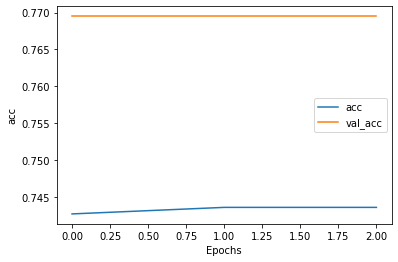

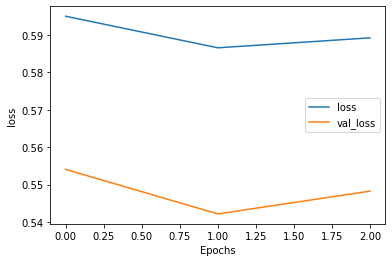

In [49]:
plot_graphs(history, "acc")
plot_graphs(history, "loss")

Predictions on a test set:

In [50]:
loss, accuracy, f1_score, precision, recall = model.evaluate([X_test_input_ids, X_test_attention_mask], y_test)
print('Test accuracy :', accuracy)

9/9 [==============================] - 12s 1s/step - loss: 0.5483 - acc: 0.7695 - f1_m: 0.7695 - precision_m: 0.7695 - recall_m: 0.7695
Test accuracy : 0.7695035338401794


In [51]:
model.metrics_names

['loss', 'acc', 'f1_m', 'precision_m', 'recall_m']

In [53]:
print('Test f1 :', f1_score)

Test f1 : 0.769497811794281


In [37]:
y_pred = model.predict([X_test_input_ids, X_test_attention_mask])

In [39]:
len(y_test)

282

In [40]:
len(y_pred)

282

In [41]:
y_pred

array([[0.14602228, 0.85397774],
       [0.14602228, 0.85397774],
       [0.14602228, 0.85397774],
       [0.14602228, 0.85397774],
       [0.14602228, 0.85397774],
       [0.14602228, 0.85397774],
       [0.14602228, 0.85397774],
       [0.14602228, 0.85397774],
       [0.14602228, 0.85397774],
       [0.14602228, 0.85397774],
       [0.14602228, 0.85397774],
       [0.14602228, 0.85397774],
       [0.14602228, 0.85397774],
       [0.14602229, 0.85397774],
       [0.14602222, 0.85397774],
       [0.14602228, 0.85397774],
       [0.14602228, 0.85397774],
       [0.14602228, 0.85397774],
       [0.14602225, 0.85397774],
       [0.14602228, 0.85397774],
       [0.14602222, 0.85397774],
       [0.14602228, 0.85397774],
       [0.14602222, 0.85397774],
       [0.14602229, 0.85397774],
       [0.14602228, 0.85397774],
       [0.14602222, 0.85397774],
       [0.14602228, 0.85397774],
       [0.14602222, 0.85397774],
       [0.14602229, 0.85397774],
       [0.14602228, 0.85397774],
       [0.

In [42]:
y_test

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.

In [38]:
from sklearn.metrics import *
# print("Accuracy ={:.2f}%".format(accuracy_score(y_test, y_pred)*100))
print("F1 score ={:.2f}%".format(f1_score(y_test,y_pred, average="weighted")*100))
# print("Precision score ={:.2f}%".format(precision_score(y_test, y_pred, average="macro")*100))
# print("Recall score ={:.2f}%".format(recall_score(y_test, y_pred, average="macro")*100))

ValueError: Classification metrics can't handle a mix of multilabel-indicator and continuous-multioutput targets

### **Summary**

For our analysis we have used a pretrained Distilbert model to resolve our  text classification problem. After trained model we achieved an accuracy on the test set equal to 93 % and it is a similar result in comparison to previous  models that we have used. We also tested a several models by adding layers and increase numbers of epochs but we do not achaived a better accuracy. 
